In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import datetime
import csv
import config
from torch.utils.data import random_split
import models
import gym
from gym import spaces
from importnb import Notebook
with Notebook():
    from jetbot_dataset import *
    from action_conditioned_diffusion_world_model_gemini import forward_diffusion_sample, linear_beta_schedule, cosine_beta_schedule, get_index_from_list  # Import necessary functions

In [13]:
class JetbotSimEnv(gym.Env):
    """
    Custom Gym environment for Jetbot simulation using a trained Diffusion World Model
    and a Reward Estimator.

    Observation: The current predicted frame (C, H, W).
    Action: A continuous value (e.g., motor speed).
    Reward: Predicted reward from the reward estimator for the predicted frame.
    """
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self, max_steps=200):
        super(JetbotSimEnv, self).__init__()

        # --- Configuration ---
        self.device = config.DEVICE
        self.image_size = config.IMAGE_SIZE
        self.num_prev_frames = config.NUM_PREV_FRAMES
        self.num_timesteps = config.NUM_TIMESTEPS
        self.use_fp16 = config.USE_FP16
        self.max_steps = max_steps
        self.current_step = 0
        self.last_action_float = None

        # --- Define action and observation space ---
        # Discrete action space (0 or 1)
        self.action_space = spaces.Discrete(2)
        # Map discrete actions to float values the model expects
        self._action_map = {0: 0.0, 1: 0.1}

        # Observation is the current frame (C, H, W) normalized to [-1, 1]
        self.observation_space = spaces.Box(
            low=-1.0, high=1.0,
            shape=(3, self.image_size, self.image_size),
            dtype=np.float32
        )

        # --- Load Models ---
        self.world_model = self._load_world_model()
        self.reward_estimator = self._load_reward_estimator()

        # --- Load Diffusion Parameters ---
        if config.SCHEDULE_TYPE == 'linear':
            self.betas = linear_beta_schedule(self.num_timesteps, config.BETA_START, config.BETA_END).to(self.device)
        elif config.SCHEDULE_TYPE == 'cosine':
            self.betas = cosine_beta_schedule(self.num_timesteps).to(self.device)
        else:
            raise ValueError(f"Invalid SCHEDULE_TYPE: {config.SCHEDULE_TYPE}")
        self.alphas = (1. - self.betas)
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

        # --- Load Real Dataset for Initialization ---
        # Use the same transform used during training
        dataset_transform = config.TRANSFORM
        try:
            self.real_dataset = JetbotDataset(
                csv_path=config.CSV_PATH,
                data_dir=config.DATA_DIR,
                image_size=self.image_size,
                num_prev_frames=self.num_prev_frames,
                transform=dataset_transform
            )
            if len(self.real_dataset) == 0:
                 raise ValueError("Loaded real dataset has zero valid samples.")
            print(f"Loaded real dataset with {len(self.real_dataset)} valid samples for initialization.")
        except Exception as e:
            print(f"ERROR: Could not load real dataset for initialization: {e}")
            self.real_dataset = None # Handle this case in reset

        # --- Internal State ---
        # These will be initialized in reset()
        self.current_frame_tensor = None # Shape: (1, C, H, W), Normalized [-1, 1]
        self.prev_frames_tensor = None # Shape: (1, N*C, H, W), Normalized [-1, 1]


    def _load_world_model(self):
        """Loads the best pre-trained world model."""
        # Find the best checkpoint (logic adapted from test_world_model.py)
        checkpoint_to_load = None
        try:
            best_checkpoints = [f for f in os.listdir(config.CHECKPOINT_DIR) if f.startswith('model_best_epoch_')]
            if best_checkpoints:
                best_checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)
                checkpoint_to_load = os.path.join(config.CHECKPOINT_DIR, best_checkpoints[0])
            elif config.LOAD_CHECKPOINT and os.path.exists(config.LOAD_CHECKPOINT):
                 checkpoint_to_load = config.LOAD_CHECKPOINT
            elif os.path.exists(os.path.join(config.CHECKPOINT_DIR, 'model_last.pth')):
                checkpoint_to_load = os.path.join(config.CHECKPOINT_DIR, 'model_last.pth')

            if not checkpoint_to_load:
                raise FileNotFoundError("No suitable world model checkpoint found.")

            print(f"Loading world model from: {checkpoint_to_load}")
            checkpoint = torch.load(checkpoint_to_load, map_location=self.device)

            # Instantiate model based on checkpoint config or current config
            model_arch_name = config.MODEL_ARCHITECTURE # Default to current config
            num_prev = config.NUM_PREV_FRAMES
            if 'config' in checkpoint and 'model_architecture' in checkpoint['config']:
                model_arch_name = checkpoint['config']['model_architecture']
                num_prev = checkpoint['config'].get('num_prev_frames', config.NUM_PREV_FRAMES)
                print(f"World model architecture from checkpoint: {model_arch_name}")
            else:
                 print(f"Warning: World model checkpoint missing arch info. Using current config: {model_arch_name}")

            if hasattr(models, model_arch_name):
                model_class = getattr(models, model_arch_name)
                model = model_class(num_prev_frames=num_prev).to(self.device)
                model.load_state_dict(checkpoint['model_state_dict'])
                model.eval()
                print(f"World model '{model_arch_name}' loaded successfully.")
                return model
            else:
                raise ValueError(f"Model class '{model_arch_name}' not found in models.py")

        except Exception as e:
            print(f"ERROR loading world model: {e}")
            raise # Re-raise the exception to halt execution if model fails to load

    def _load_reward_estimator(self):
        """Loads the best pre-trained reward estimator model."""
        # Path determined from reward_estimator_training.py logic
        reward_model_dir = os.path.join(config.OUTPUT_DIR, 'reward_estimator')
        model_path = os.path.join(reward_model_dir, "reward_estimator_best.pth") # Best model path

        if not os.path.exists(model_path):
            # Fallback to final if best not found
             model_path_final = os.path.join(reward_model_dir, "reward_estimator_single_frame_final.pth")
             if os.path.exists(model_path_final):
                  model_path = model_path_final
             else:
                  raise FileNotFoundError(f"Reward estimator checkpoint not found at {model_path} or {model_path_final}")


        print(f"Loading reward estimator from: {model_path}")
        try:
            # Assuming SimpleRewardEstimator class is defined in models.py
            model = models.SimpleRewardEstimator().to(self.device)
            model.load_state_dict(torch.load(model_path, map_location=self.device))
            model.eval()
            print("Reward estimator loaded successfully.")
            return model
        except Exception as e:
            print(f"ERROR loading reward estimator: {e}")
            raise # Re-raise

    def _predict_next_frame(self, current_frame_tensor, prev_frames_tensor, action_tensor):
        """Predicts the next frame using the diffusion world model."""
        with torch.no_grad():
            # Prepare for denoising (start from max noise)
            t_sample = torch.tensor([self.num_timesteps - 1], device=self.device, dtype=torch.long)
            # Use a dummy frame to start denoising process? Or noise the current frame?
            # Let's noise the *current* frame to start the reverse process
            # Note: forward_diffusion_sample needs tensors, ensure inputs are tensors
            if not isinstance(self.betas, torch.Tensor): self.betas = torch.tensor(self.betas, device=self.device)
            if not isinstance(self.alphas_cumprod, torch.Tensor): self.alphas_cumprod = torch.tensor(self.alphas_cumprod, device=self.device)

            x_noisy, _ = forward_diffusion_sample(current_frame_tensor, t_sample, self.betas, self.alphas_cumprod, self.device)
            x = x_noisy # Start denoising from noisy version of current frame

            # Reverse diffusion loop
            for i in reversed(range(1, self.num_timesteps)):
                t = (torch.ones(1) * i).long().to(self.device) # Batch size 1
                with torch.cuda.amp.autocast(enabled=self.use_fp16):
                    predicted_noise = self.world_model(x, t, action_tensor, prev_frames_tensor)

                # Get schedule constants for time t
                alpha_t = get_index_from_list(self.alphas, t, x.shape)
                alpha_t_cumprod = get_index_from_list(self.alphas_cumprod, t, x.shape)
                beta_t = get_index_from_list(self.betas, t, x.shape)
                sqrt_one_minus_alpha_t_cumprod = get_index_from_list(torch.sqrt(1.0 - self.alphas_cumprod), t, x.shape)
                sqrt_recip_alpha_t = get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)


                # DDPM Denoising step formula
                model_mean = sqrt_recip_alpha_t * (x - beta_t * predicted_noise / sqrt_one_minus_alpha_t_cumprod)
                if i > 1:
                    posterior_variance = get_index_from_list(self.betas, t, x.shape) # Simplified variance
                    noise = torch.randn_like(x)
                    x = model_mean + torch.sqrt(posterior_variance) * noise
                else:
                    x = model_mean # No noise at the last step

            # x is the predicted next frame in range [-1, 1]
            return x.clamp(-1.0, 1.0)

    def _estimate_reward(self, predicted_frame_tensor):
        """Estimates reward for the predicted frame."""
        with torch.no_grad():
            # Reward model expects single frame (B, C, H, W)
            reward = self.reward_estimator(predicted_frame_tensor)
            return reward.item() # Return scalar reward

    def step(self, action):
        """Run one timestep of the environment's dynamics."""
        if not self.action_space.contains(action):
            raise ValueError(f"Invalid action: {action}. Action must be 0 or 1.")

        self.current_step += 1

        # --- Map discrete action index to float value ---
        action_float = self._action_map[action]
        # MODIFIED: Store the action taken
        self.last_action_float = action_float
        action_tensor = torch.tensor([[action_float]], dtype=torch.float32, device=self.device) # Shape: (1, 1)

        # --- Predict Next State ---
        predicted_next_frame = self._predict_next_frame(
            self.current_frame_tensor, self.prev_frames_tensor, action_tensor
        ) # Shape: (1, C, H, W)

        # --- Estimate Reward ---
        reward = self._estimate_reward(predicted_next_frame)

        # --- Update Internal State ---
        # Update previous frames: shift history, add the frame that *was* current
        new_prev_frames = torch.cat([self.prev_frames_tensor[:, 3:, :, :], self.current_frame_tensor], dim=1)
        self.prev_frames_tensor = new_prev_frames
        # Update current frame to the newly predicted one
        self.current_frame_tensor = predicted_next_frame

        # --- Determine Done ---
        done = self.current_step >= self.max_steps

        # --- Observation ---
        # Return the predicted frame as observation (remove batch dim, convert to numpy)
        observation = self.current_frame_tensor.squeeze(0).cpu().numpy()

        # --- Info ---
        info = {'action_taken': self.last_action_float}

        return observation, reward, done, info

    def reset(self):
        """Resets the environment to an initial state."""
        self.current_step = 0
        self.last_action_float = None # Reset last action on reset

        if self.real_dataset is None:
            print("ERROR: Real dataset not loaded. Cannot reset environment.")
            # Return a dummy observation or raise error
            return np.zeros(self.observation_space.shape, dtype=self.observation_space.dtype)

        # Sample a random valid starting point from the real dataset
        random_start_idx = random.randint(0, len(self.real_dataset) - 1)
        # index for debugging where frame has a kong and motion is predicted
        # random_start_idx = 928
        current_frame, _, prev_frames = self.real_dataset[random_start_idx]

        # Initialize internal state tensors (add batch dimension and move to device)
        self.current_frame_tensor = current_frame.unsqueeze(0).to(self.device)
        self.prev_frames_tensor = prev_frames.unsqueeze(0).to(self.device)

        # Return the initial observation
        observation = self.current_frame_tensor.squeeze(0).cpu().numpy()
        return observation

    def render(self, mode='human'):
        """
        Renders the environment's current frame.
        In 'human' mode, displays the image inline using matplotlib.
        In 'rgb_array' mode, returns the frame as a NumPy array.
        """
        if self.current_frame_tensor is None:
            print("Cannot render: Environment not initialized.")
            return None

        # Convert current frame tensor to displayable format (NumPy array [0, 255])
        img_tensor = self.current_frame_tensor.squeeze(0).cpu() # Remove batch dim
        img_tensor = (img_tensor.clamp(-1, 1) + 1) / 2 # Unnormalize to [0, 1]
        # Permute C, H, W to H, W, C for matplotlib/numpy image format
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = (img_np * 255).astype(np.uint8) # Scale to [0, 255]

        if mode == 'rgb_array':
            return img_np
        elif mode == 'human':
            # MODIFIED: Use matplotlib for inline display
            plt.figure(figsize=(4, 4)) # Adjust size as needed
            action_str = f"{self.last_action_float:.1f}" if self.last_action_float is not None else "N/A (Initial State)"
            plt.title(f"Step: {self.current_step}, Action Taken: {action_str}")
            plt.imshow(img_np)
            plt.axis('off')
            plt.show() # Display the plot in the notebook cell
            return None # Human mode typically doesn't return the array
        else:
            super(JetbotSimEnv, self).render(mode=mode) # Call gym's default render for other modes


    def close(self):
        """Perform any necessary cleanup."""
        pass



Testing JetbotSimEnv...
Loading world model from: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_output\checkpoints\model_best_epoch_70.pth
World model architecture from checkpoint: SimpleUNetV1
World model 'SimpleUNetV1' loaded successfully.
Loading reward estimator from: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_output\reward_estimator\reward_estimator_best.pth
Reward estimator loaded successfully.
Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Total rows in CSV: 23081, Valid sequence start indices: 23037
Loaded real dataset with 23037 valid samples for initialization.
Initial Observation Shape: (3, 224, 224)
Step: 1, Action: 1


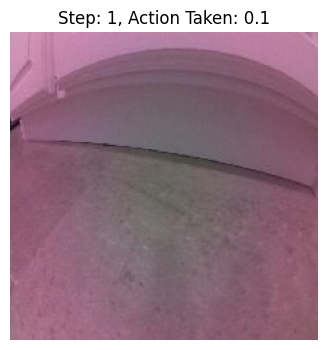

Step: 11, Action: 1


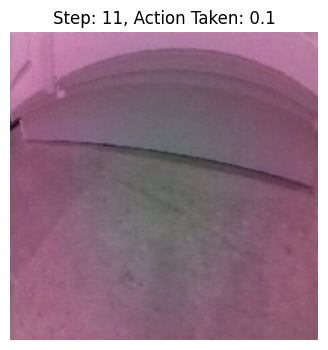

Step: 50, Action: 1


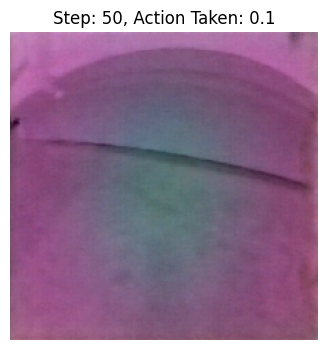


Episode finished after 50 steps.
Total Reward: 30.3290


In [14]:
# --- Example Usage (Optional) ---
if __name__ == '__main__':
    print("Testing JetbotSimEnv...")
    env = JetbotSimEnv(max_steps=50)
    obs = env.reset()

    print("Initial Observation Shape:", obs.shape)

    total_reward = 0
    for step in range(env.max_steps):
        # action = env.action_space.sample() # Sample random action
        action = 1
        
        obs, reward, done, info = env.step(action)
        # print(f"  Observation Shape: {obs.shape}, Reward: {reward:.4f}, Done: {done}")
        total_reward += reward
        if (step == 0 or step == 10 or step == env.max_steps-1):
            print(f"Step: {step+1}, Action: {action}")
            env.render(mode='human') # Can uncomment to show frames (might open many windows)
        # time.sleep(0.5) # Slow down visualization
        if done:
            break

    print(f"\nEpisode finished after {env.current_step} steps.")
    print(f"Total Reward: {total_reward:.4f}")
    env.close()